# Aim
A linear regression analysis is applied to check whether visual network (VIS) and Dorsal Attention Network (DAN) or Default Mode Network (DMN) are hierarchically connected to each other.
# Data analysis order
1. Load all the data (connectivity during attention and resting) : connAtten, connRest
2. Extract only necessary part of the data and reorganize it
 (connectivity between DAN-VIS, DMN-VIS)
3. Linear regression fit : gain, base will be obtained
4. Visualize the Linear Regression plot
5. Visualize the Gain, Base (as a bar plot)

In [1]:
# load libraries (python2)
import pandas as pd
import scipy 
import numpy as np
import scipy.io as sio
import os
import fnmatch, re
import glob
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Define Basic

In [2]:
# Define basie parameters
n_roi = 24; n_subj = 20
danI = list(range(5,9)); visI = list(range(0,5))

# Directory setup
# dir_main = '/Users/soyoung/Atten_Conn/'
# dir_connectivity = dir_main + "/01_DataConnectivity/"
# dir_connectivity = dir_main + "/26_ROI_Conn_Subj/"

dir_main = "/Volumes/SoyoungBackup/Mac_HD3/Atten_Motion_OnOff/LinearRegression_Connectivity/"
dir_connectivity = dir_main + "/01_DataConnectivity/"
filetype = "Conn_rand32_craf_regMotionWM_highnone_low0_P_shift20_regMeanSubjVox_sub*[!wrong][!retino].mat"

# 1. Load the data

In [3]:
def load_data_group(dir_connectivity, filetype, cond):
    # Load the file list
    conn_list = [f for f in glob.glob(dir_connectivity + filetype)]
    
    # Predefine group data and assign it
    conn_group = np.zeros([n_roi, n_roi, n_subj])
    for s in range(n_subj):
        conn_subj = sio.loadmat(conn_list[s])
        conn_group[:,:,s] = np.mean(conn_subj[cond], axis = 2)
    return conn_group

In [4]:
conn_group_atten = load_data_group(dir_connectivity, filetype, 'corrAtten')
conn_group_rest = load_data_group(dir_connectivity, filetype, 'corrRest')

conn_group = {'atten': conn_group_atten,
             'rest': conn_group_rest}

# 2. Extract & reorganize data
1. Extract Left, Right Data => L-L, L-R, R-R, R-L
2. Extract DAN-VIS, DMN-VIS

In [24]:
# Data Extract
# Reshape into one hemi only (n_roi,n_roi,all_subj) ==> (n_roi/2, n_roi/2, all_subj)
# Extract only DAN(DMN)-VIS (FEF,IPS,PCC,MFC- V1,V2,V3,V4,V5/MT) ==> (4,5,all_subj)
def data_reorg_dxn_only(data_both, which):
    # DAN hemisphere (L : odd, R: even)
    [n_roi, n_roi, n_subj] = data_both.shape
    if which == 'L': oddeven = 0
    elif which == 'R': oddeven = 1
    data_half_test = data_both[list(range(oddeven, n_roi, 2)), :, :] # DAN hemi (input)
    data_half_XL   = data_half_test[:, list(range(0, n_roi, 2)), :] # VIS hemi(L)
    data_half_XR   = data_half_test[:, list(range(1, n_roi, 2)), :] # VIS hemi(R)
    
    # combine LL+LR
    dataLR = np.zeros([n_roi/2, n_roi/2, n_subj, 2])
    dataLR[:,:,:,0] = data_half_XL; dataLR[:,:,:,1] = data_half_XR;
    dataLR = np.mean(dataLR, axis=3)   
    
    # only extract visIndex, DXN index
    All_VIS = dataLR[:,visI,:]
    DXN_VIS = All_VIS[danI,:,:]
    
    return DXN_VIS

In [26]:
# conn_atten_L = data_reorg_LR(conn_group['atten'], 'L')
DXN_VIS_atten_L = data_reorg_dxn_only(conn_group['atten'], 'L')
DXN_VIS_atten_R = data_reorg_dxn_only(conn_group['atten'], 'R')
DXN_VIS_atten_L.shape

(4, 5, 20)

In [27]:
# change to pandas
DXN_Name = ['FEF','IPS','MFC','PCC']
DXN_atten_L = pd.DataFrame(zip(*DXN_VIS_atten_L[:,:,0]), columns = DXN_Name)
DXN_atten_R = pd.DataFrame(zip(*DXN_VIS_atten_R[:,:,0]), columns = DXN_Name)


In [28]:
b = {'atten' : DXN_atten_L,
     'rest'  : DXN_atten_R}
type(b['atten'])

pandas.core.frame.DataFrame

# 3. Linear Regression

In [29]:
# Linear Regression
def linear_regression(X, Y):
    return gain, base

In [30]:
X = pd.DataFrame(np.arange(5))
Y = b['atten']
X.shape, Y.shape
lr = LinearRegression()#(normalize=True)
lr.fit(X, Y)
pred_Y= lr.predict(X)

In [68]:
lr.coef_[3], lr.intercept_[3]
Y[DXN_Name[0]]
DXN_VIS_atten_L.shape

(4, 5, 20)

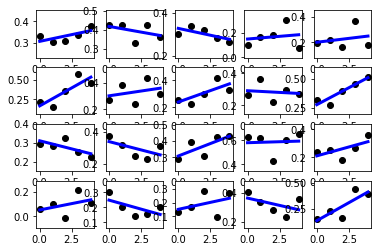

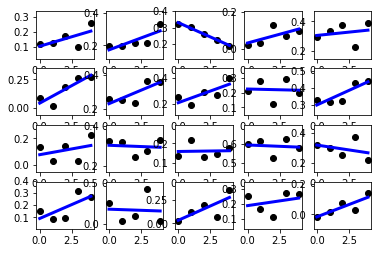

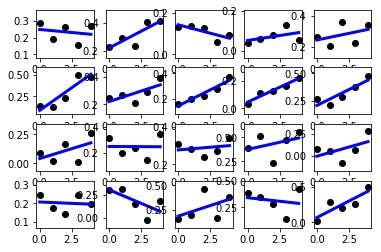

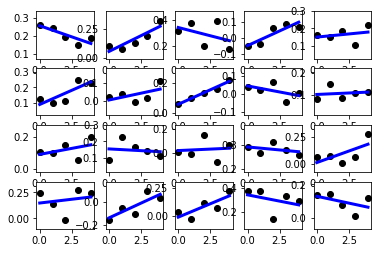

In [79]:
# Linear regression in each subject
DXN_Name = ['FEF','IPS','MFC','PCC']
X = pd.DataFrame(np.arange(5))
gain = np.zeros([n_subj, 4])
base = np.zeros([n_subj, 4])
for dxn in range(4):
    fig = plt.figure()
    dxn_name = DXN_Name[dxn]
    for s in range(n_subj):
        DXN_atten_L = pd.DataFrame(zip(*DXN_VIS_atten_L[:,:,s]), columns = DXN_Name)
        DXN_atten_R = pd.DataFrame(zip(*DXN_VIS_atten_R[:,:,s]), columns = DXN_Name)
        DXN_atten = {'L' : DXN_atten_L,
                     'R' : DXN_atten_R}
        Y = DXN_atten['L'].iloc[:,dxn]
        lr = LinearRegression()#(normalize=True)
        lr.fit(X, Y)
        gain[s,dxn] = lr.coef_
        base[s,dxn] = lr.intercept_
        pred_Y = lr.predict(X)
        plt.subplot(4,5,s+1)
        plt.scatter(X, Y, color='black')
        plt.plot(X, pred_Y, color='blue', linewidth = 3)
    plt.show()

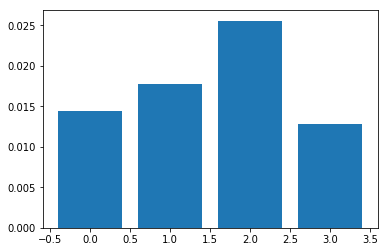

In [89]:
# plt.bar()
a=np.mean(gain, axis=0)
plt.bar(np.arange(4), a)
plt.show()

In [60]:
gain[s,:]

array([0., 0., 0., 0.])

In [67]:
gain[s,:] = zip(*(lr.coef_))

ValueError: setting an array element with a sequence.